In [21]:
import geopandas as gpd

# 1. Read the OSM POIs shapefile that you actually have
OSM = gpd.read_file("gis_osm_pois_a_free_1.shp")

# 2. Set CRS if missing, then transform to 27700
if OSM.crs is None:
    OSM = OSM.set_crs(epsg=4326)
OSM = OSM.to_crs(epsg=27700)

# 3. See what columns exist so you know how to filter for hotels
print(OSM.columns)
OSM.head()





Index(['geometry'], dtype='object')


,geometry
0,"POLYGON ((529379.588 163445.613, 529390.921 16..."
1,"POLYGON ((532065.726 197873.867, 532093.379 19..."
2,"POLYGON ((532863.867 198097.732, 532874.832 19..."
3,"POLYGON ((532439.439 197659.703, 532438.091 19..."
4,"POLYGON ((532707.357 197545.844, 532728.192 19..."


In [22]:
import pandas as pd
import geopandas as gpd

df = pd.read_csv("20250615-London-listings .csv")

airbnb_gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df["longitude"], df["latitude"]),
    crs="EPSG:4326"
).to_crs(epsg=27700)


In [24]:
def counting_landlords(condition):
    landlord_count = df[condition]["host_id"].nunique() 
    host_count = df["host_id"].nunique() 
    print(f"The count of all hosts in london is {host_count}.")
    print(f"The count of all professional landlords in london is {landlord_count}.")
    print(f"The proportion of professional landlords among all hosts is {landlord_count*100/host_count:.2f}%.")


In [25]:
Multi_listing_Hosts = df["host_listings_count"] > 1
Commerical_Hosts = df["availability_365"] >= 180

In [26]:
counting_landlords(Multi_listing_Hosts)

The count of all hosts in london is 47775.
The count of all professional landlords in london is 13832.
The proportion of professional landlords among all hosts is 28.95%.


In [29]:
counting_landlords(Commerical_Hosts)

The count of all hosts in london is 47775.
The count of all professional landlords in london is 17619.
The proportion of professional landlords among all hosts is 36.88%.


In [28]:
counting_landlords(Multi_listing_Hosts&Commerical_Hosts)

The count of all hosts in london is 47775.
The count of all professional landlords in london is 7224.
The proportion of professional landlords among all hosts is 15.12%.


Total unique hosts: 47775
Professional landlords (unique hosts): 7224
Proportion: 15.12%


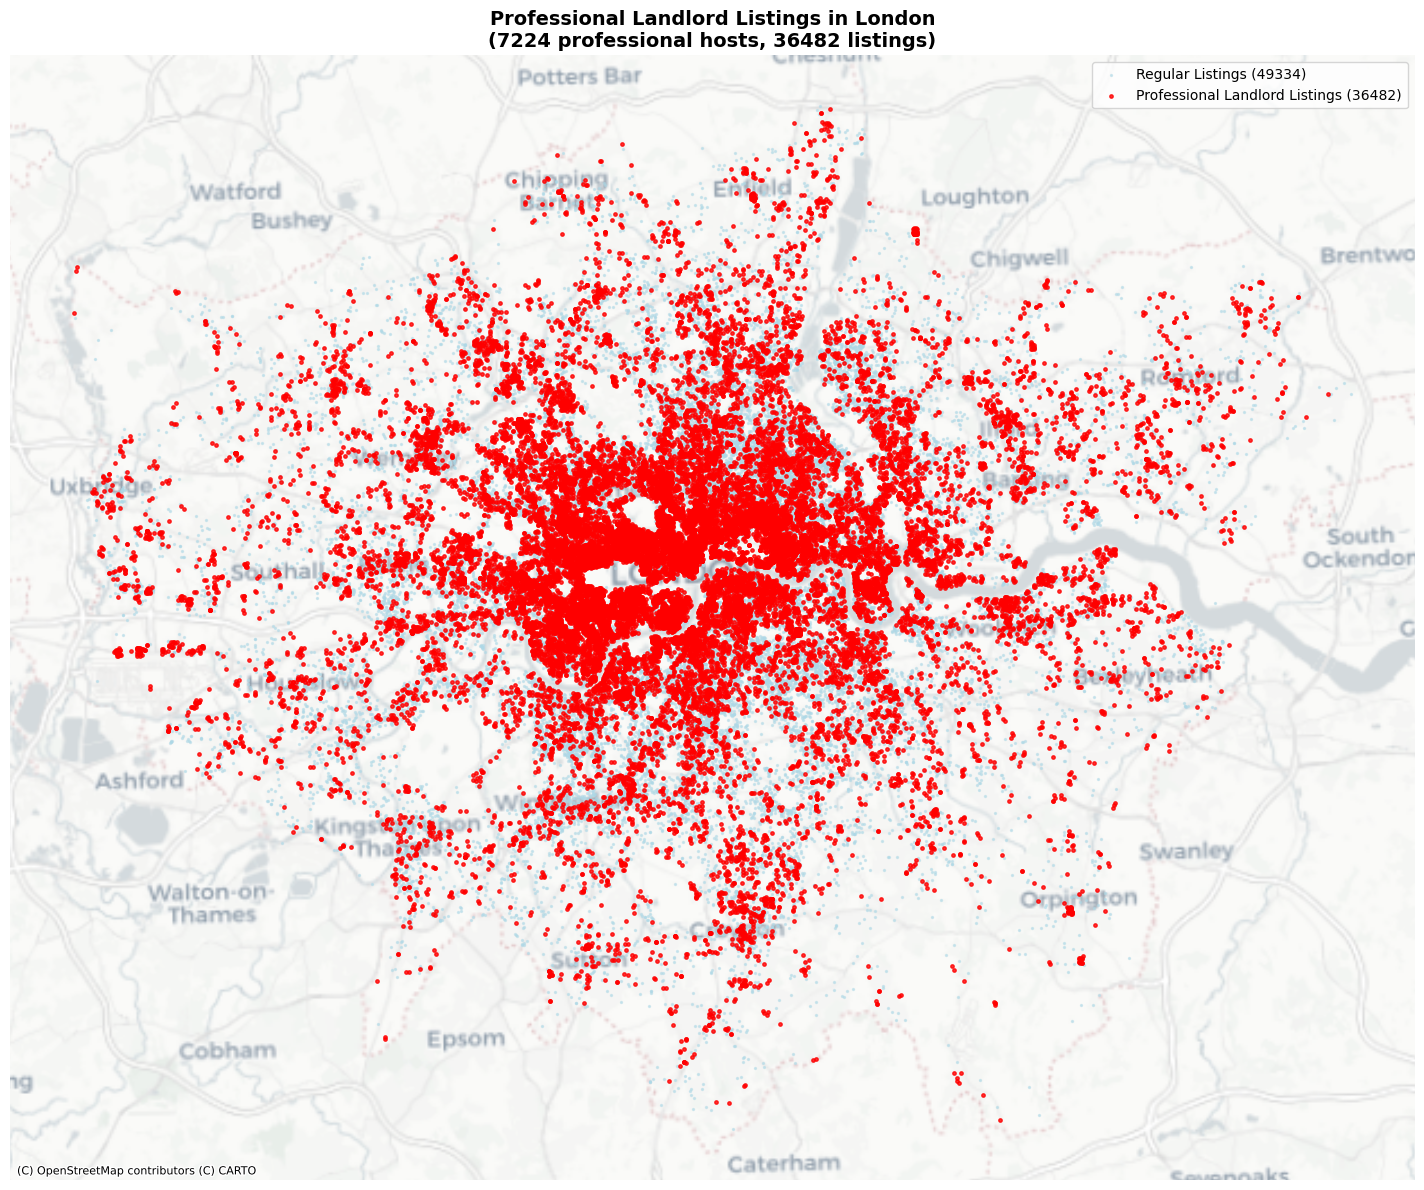


DETAILED STATISTICS
Total unique hosts: 47775
Professional landlords (unique hosts): 7224
Proportion of professional landlords: 15.12%
Total listings: 85816
Listings from professional landlords: 36482
Proportion of professional listings: 42.51%

Average listings per professional landlord: 5.05
Average listings per regular host: 1.22


In [34]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

# Read and prepare Airbnb data
df = pd.read_csv("20250615-London-listings .csv")

# Create GeoDataFrame
airbnb_gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df["longitude"], df["latitude"]),
    crs="EPSG:4326"
).to_crs(epsg=27700)

# Define professional landlords criteria (same as your function)
Multi_listing_Hosts = df["host_listings_count"] > 1
Commerical_Hosts = df["availability_365"] >= 180
professional_criteria = Multi_listing_Hosts & Commerical_Hosts

# Get unique professional host IDs
professional_host_ids = df[professional_criteria]["host_id"].unique()
all_host_ids = df["host_id"].unique()

print(f"Total unique hosts: {len(all_host_ids)}")
print(f"Professional landlords (unique hosts): {len(professional_host_ids)}")
print(f"Proportion: {len(professional_host_ids)*100/len(all_host_ids):.2f}%")

# Create a column to identify professional landlord listings
airbnb_gdf['is_professional'] = professional_criteria

# For mapping, we need to identify which listings belong to professional landlords
# We'll create a column that marks listings from professional landlords
professional_listings_mask = airbnb_gdf['host_id'].isin(professional_host_ids)
professional_listings_gdf = airbnb_gdf[professional_listings_mask]
regular_listings_gdf = airbnb_gdf[~professional_listings_mask]

# Create the plot
fig, ax = plt.subplots(1, 1, figsize=(15, 12))

# Plot regular listings
regular_listings_gdf.plot(ax=ax, color='lightblue', markersize=2, alpha=0.5, 
                         label=f'Regular Listings ({len(regular_listings_gdf)})')

# Plot professional landlord listings
professional_listings_gdf.plot(ax=ax, color='red', markersize=6, alpha=0.8, 
                              label=f'Professional Landlord Listings ({len(professional_listings_gdf)})')

# Customize the plot
ax.set_title('Professional Landlord Listings in London\n'
            f'({len(professional_host_ids)} professional hosts, {len(professional_listings_gdf)} listings)', 
            fontsize=14, fontweight='bold')

# Add basemap
try:
    ctx.add_basemap(ax, crs=airbnb_gdf.crs, source=ctx.providers.CartoDB.Positron)
except:
    print("Contextily basemap not available - using plain background")

ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)
ax.set_axis_off()  # Remove axes for cleaner look

plt.tight_layout()
plt.show()

# Detailed statistics
print("\n" + "="*50)
print("DETAILED STATISTICS")
print("="*50)
print(f"Total unique hosts: {len(all_host_ids)}")
print(f"Professional landlords (unique hosts): {len(professional_host_ids)}")
print(f"Proportion of professional landlords: {len(professional_host_ids)*100/len(all_host_ids):.2f}%")
print(f"Total listings: {len(airbnb_gdf)}")
print(f"Listings from professional landlords: {len(professional_listings_gdf)}")
print(f"Proportion of professional listings: {len(professional_listings_gdf)*100/len(airbnb_gdf):.2f}%")

# Additional insights
avg_listings_per_professional = len(professional_listings_gdf) / len(professional_host_ids)
avg_listings_per_regular = len(regular_listings_gdf) / (len(all_host_ids) - len(professional_host_ids))

print(f"\nAverage listings per professional landlord: {avg_listings_per_professional:.2f}")
print(f"Average listings per regular host: {avg_listings_per_regular:.2f}")

In [51]:
import pandas as pd

# Read data
df = pd.read_csv("20250615-London-listings .csv")

# Define professional landlords EXACTLY as specified
Multi_listing_Hosts = df["host_listings_count"] > 1
Commerical_Hosts = df["availability_365"] >= 180
professional = Multi_listing_Hosts & Commerical_Hosts

# Count professional landlords (as in your function)
def counting_landlords(condition):
    landlord_count = df[condition]["host_id"].nunique() 
    host_count = df["host_id"].nunique() 
    print(f"The count of all hosts in london is {host_count:,}.")
    print(f"The count of all professional landlords in london is {landlord_count:,}.")
    print(f"The proportion of professional landlords among all hosts is {landlord_count*100/host_count:.2f}%.")

# Run the counting function
counting_landlords(professional)

# Define all 32 London boroughs with coordinate boundaries
def get_borough(lat, lon):
    """Assign borough based on latitude/longitude ranges for all 32 London boroughs"""
    
    # Central London boroughs
    if 51.49 <= lat <= 51.52 and -0.20 <= lon <= -0.14: return 'Westminster'
    elif 51.53 <= lat <= 51.56 and -0.15 <= lon <= -0.10: return 'Camden'
    elif 51.48 <= lat <= 51.51 and -0.22 <= lon <= -0.17: return 'Kensington and Chelsea'
    elif 51.51 <= lat <= 51.54 and -0.12 <= lon <= -0.08: return 'Islington'
    
    # North London boroughs
    elif 51.54 <= lat <= 51.57 and -0.10 <= lon <= -0.05: return 'Hackney'
    elif 51.56 <= lat <= 51.59 and -0.15 <= lon <= -0.10: return 'Haringey'
    elif 51.57 <= lat <= 51.60 and -0.10 <= lon <= -0.05: return 'Waltham Forest'
    elif 51.55 <= lat <= 51.58 and -0.25 <= lon <= -0.20: return 'Brent'
    elif 51.57 <= lat <= 51.60 and -0.25 <= lon <= -0.20: return 'Harrow'
    elif 51.59 <= lat <= 51.62 and -0.20 <= lon <= -0.15: return 'Barnet'
    elif 51.60 <= lat <= 51.63 and -0.10 <= lon <= -0.05: return 'Redbridge'
    elif 51.58 <= lat <= 51.61 and -0.05 <= lon <= 0.00: return 'Havering'
    
    # East London boroughs
    elif 51.50 <= lat <= 51.53 and -0.07 <= lon <= -0.02: return 'Tower Hamlets'
    elif 51.48 <= lat <= 51.51 and -0.05 <= lon <= 0.00: return 'Newham'
    elif 51.51 <= lat <= 51.54 and -0.03 <= lon <= 0.02: return 'Barking and Dagenham'
    elif 51.46 <= lat <= 51.49 and -0.03 <= lon <= 0.02: return 'Bexley'
    elif 51.44 <= lat <= 51.47 and 0.00 <= lon <= 0.05: return 'Greenwich'
    
    # South London boroughs
    elif 51.46 <= lat <= 51.49 and -0.13 <= lon <= -0.08: return 'Lambeth'
    elif 51.48 <= lat <= 51.51 and -0.10 <= lon <= -0.06: return 'Southwark'
    elif 51.44 <= lat <= 51.47 and -0.22 <= lon <= -0.17: return 'Wandsworth'
    elif 51.45 <= lat <= 51.48 and -0.17 <= lon <= -0.12: return 'Merton'
    elif 51.41 <= lat <= 51.44 and -0.22 <= lon <= -0.17: return 'Kingston upon Thames'
    elif 51.39 <= lat <= 51.42 and -0.30 <= lon <= -0.25: return 'Richmond upon Thames'
    elif 51.42 <= lat <= 51.45 and -0.15 <= lon <= -0.10: return 'Sutton'
    elif 51.40 <= lat <= 51.43 and -0.12 <= lon <= -0.07: return 'Croydon'
    elif 51.43 <= lat <= 51.46 and -0.08 <= lon <= -0.03: return 'Bromley'
    elif 51.45 <= lat <= 51.48 and -0.05 <= lon <= 0.00: return 'Lewisham'
    
    # West London boroughs
    elif 51.48 <= lat <= 51.51 and -0.23 <= lon <= -0.20: return 'Hammersmith and Fulham'
    elif 51.50 <= lat <= 51.53 and -0.25 <= lon <= -0.20: return 'Ealing'
    elif 51.52 <= lat <= 51.55 and -0.30 <= lon <= -0.25: return 'Hillingdon'
    elif 51.49 <= lat <= 51.52 and -0.30 <= lon <= -0.25: return 'Hounslow'
    
    else: return 'Other'

# Assign boroughs to each listing
df['borough'] = df.apply(lambda row: get_borough(row['latitude'], row['longitude']), axis=1)

# Add professional flag to dataframe
df['is_professional'] = professional

print("\n" + "="*90)
print("AVERAGE PRICES FOR ALL 32 LONDON BOROUGHS")
print("="*90)

# Calculate average prices per borough
borough_stats = []
all_boroughs = [
    'Westminster', 'Camden', 'Kensington and Chelsea', 'Islington',
    'Hackney', 'Haringey', 'Waltham Forest', 'Brent', 'Harrow', 'Barnet', 
    'Redbridge', 'Havering', 'Tower Hamlets', 'Newham', 'Barking and Dagenham',
    'Bexley', 'Greenwich', 'Lambeth', 'Southwark', 'Wandsworth', 'Merton',
    'Kingston upon Thames', 'Richmond upon Thames', 'Sutton', 'Croydon', 
    'Bromley', 'Lewisham', 'Hammersmith and Fulham', 'Ealing', 'Hillingdon',
    'Hounslow'
]

for borough in all_boroughs:
    borough_data = df[df['borough'] == borough]
    
    if len(borough_data) > 0:
        prof_data = borough_data[borough_data['is_professional']]
        reg_data = borough_data[~borough_data['is_professional']]
        
        borough_stats.append({
            'Borough': borough,
            'Avg_Price_All': borough_data['price'].mean(),
            'Avg_Price_Prof': prof_data['price'].mean() if len(prof_data) > 0 else 0,
            'Avg_Price_Reg': reg_data['price'].mean() if len(reg_data) > 0 else 0,
            'Total_Listings': len(borough_data),
            'Prof_Listings': len(prof_data),
            'Reg_Listings': len(reg_data)
        })
    else:
        # Borough exists but no listings in our data
        borough_stats.append({
            'Borough': borough,
            'Avg_Price_All': 0,
            'Avg_Price_Prof': 0,
            'Avg_Price_Reg': 0,
            'Total_Listings': 0,
            'Prof_Listings': 0,
            'Reg_Listings': 0
        })

# Create results dataframe
results = pd.DataFrame(borough_stats).round(2)

# Sort by average price (highest first)
results = results.sort_values('Avg_Price_All', ascending=False)

# Display results
print(f"{'Borough':<25} {'All£':<8} {'Prof£':<8} {'Reg£':<8} {'Diff£':<8} {'Listings':<10} {'Prof%':<8}")
print("-"*90)

for _, row in results.iterrows():
    if row['Total_Listings'] > 0:
        price_diff = row['Avg_Price_Prof'] - row['Avg_Price_Reg']
        prof_pct = (row['Prof_Listings'] / row['Total_Listings']) * 100
        print(f"{row['Borough']:<25} £{row['Avg_Price_All']:<7.0f} £{row['Avg_Price_Prof']:<7.0f} "
              f"£{row['Avg_Price_Reg']:<7.0f} £{price_diff:<7.0f} {row['Total_Listings']:<10,} {prof_pct:<7.1f}%")
    else:
        print(f"{row['Borough']:<25} {'No data':<45} {row['Total_Listings']:<10,}")

# Summary statistics
print(f"\n{'SUMMARY STATISTICS':^90}")
print("="*90)

total_listings = results['Total_Listings'].sum()
boroughs_with_data = len(results[results['Total_Listings'] > 0])

print(f"Boroughs with data: {boroughs_with_data}/32")
print(f"Total listings analyzed: {total_listings:,}")
print(f"Overall London average price: £{df['price'].mean():.2f}")
print(f"Professional landlord average: £{df[professional]['price'].mean():.2f}")
print(f"Regular host average: £{df[~professional]['price'].mean():.2f}")
print(f"Price difference: £{df[professional]['price'].mean() - df[~professional]['price'].mean():.2f}")

# Verify professional landlord definition matches your function
print(f"\n{'VERIFICATION OF PROFESSIONAL LANDLORD DEFINITION':^90}")
print("-"*90)
print(f"Professional landlords defined as: host_listings_count > 1 AND availability_365 >= 180")
print(f"Professional listings count: {professional.sum():,}")
print(f"Professional hosts count: {df[professional]['host_id'].nunique():,}")


The count of all hosts in london is 47,775.
The count of all professional landlords in london is 7,224.
The proportion of professional landlords among all hosts is 15.12%.

AVERAGE PRICES FOR ALL 32 LONDON BOROUGHS
Borough                   All£     Prof£    Reg£     Diff£    Listings   Prof%   
------------------------------------------------------------------------------------------
Westminster               £395     £430     £359     £71      8,319      42.3   %
Haringey                  £245     £170     £278     £-108    1,364      20.1   %
Kensington and Chelsea    £241     £249     £236     £14      2,691      31.4   %
Islington                 £235     £261     £210     £51      3,018      35.6   %
Wandsworth                £201     £229     £189     £41      1,667      20.9   %
Camden                    £200     £250     £170     £80      3,899      26.4   %
Ealing                    £197     £217     £185     £32      1,905      28.2   %
Southwark                 £193     £23